<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [2]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


Label is: 3
Image shape: torch.Size([3, 32, 32])


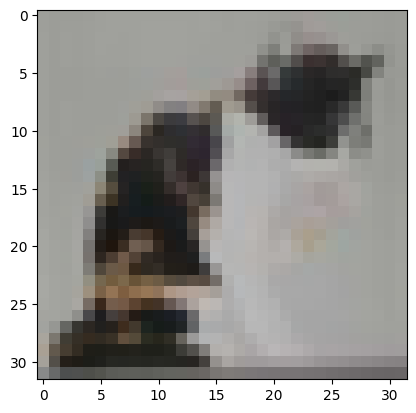

In [3]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [4]:
#Creating dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)


In [5]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

In [6]:
means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)
means_test, stds_test = compute_mean_std_dataset(test_dataset)
print(means_train, stds_train)
print(means_val, stds_val)
print(means_test, stds_test)

(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))
(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))
(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))


In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train)])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_test, stds_test)])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [8]:
means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)
means_test, stds_test = compute_mean_std_dataset(test_dataset)
print(means_train, stds_train)
print(means_val, stds_val)
print(means_test, stds_test)

(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))
(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))
(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))


# **II. Model implementation**

In [13]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.ReLU())


  def forward(self, x):
    return self.conv_layer(x)

In [16]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [43]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims):
    super().__init__()
    self.in_channels = in_channels
    self
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([Conv_layer(cin, cout, kernel) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(fc_dims[:-1], fc_dims[1:])])

  def forward(self, x):
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers:
      x = fc_layer(x)
    return x


# **III. Training and test**

In [44]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 16)
out_channels = (16, 32)
conv_kernels = (5, 5)
fc_dims = (out_channels[-1]*5*5, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

My_CNN(
  (conv_layers): ModuleList(
    (0): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
    (1): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=800, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [45]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 117866
Device is cpu


In [46]:
if device=="cuda": model = torch.compile(model)

In [47]:
#Training and validation
nb_epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
      if loss.item() < best_loss:
          best_loss = loss.item()
          best_model, best_epoch = model, epoch
    loss_val /= len(test_loader)
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {epoch}")

epochs = range(nb_epochs)
plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

Epoch: 0


782it [00:34, 22.42it/s]
79it [00:02, 31.40it/s]


Loss_train: 1.8811 and loss_val: 1.6434
Epoch: 1


782it [00:33, 23.68it/s]
79it [00:01, 40.96it/s]


Loss_train: 1.5845 and loss_val: 1.5104
Epoch: 2


782it [00:33, 23.41it/s]
79it [00:01, 40.37it/s]


Loss_train: 1.4896 and loss_val: 1.4733
Epoch: 3


782it [00:33, 23.35it/s]
79it [00:01, 40.67it/s]


Loss_train: 1.4354 and loss_val: 1.4041
Epoch: 4


782it [00:33, 23.46it/s]
79it [00:01, 41.08it/s]


Loss_train: 1.3896 and loss_val: 1.3801
Epoch: 5


782it [00:32, 23.71it/s]
79it [00:02, 33.55it/s]


Loss_train: 1.3495 and loss_val: 1.3355
Epoch: 6


782it [00:32, 23.70it/s]
79it [00:02, 30.62it/s]


Loss_train: 1.3163 and loss_val: 1.3076
Epoch: 7


782it [00:32, 24.23it/s]
79it [00:01, 41.39it/s]


Loss_train: 1.2884 and loss_val: 1.2948
Epoch: 8


782it [00:34, 22.71it/s]
79it [00:01, 41.13it/s]


Loss_train: 1.2627 and loss_val: 1.2752
Epoch: 9


782it [00:33, 23.50it/s]
79it [00:01, 41.58it/s]


Loss_train: 1.2412 and loss_val: 1.2388
Epoch: 10


782it [00:32, 23.78it/s]
79it [00:01, 40.12it/s]


Loss_train: 1.2216 and loss_val: 1.2186
Epoch: 11


782it [00:32, 24.37it/s]
79it [00:02, 33.61it/s]


Loss_train: 1.2025 and loss_val: 1.2111
Epoch: 12


782it [00:32, 24.06it/s]
79it [00:01, 41.79it/s]


Loss_train: 1.1851 and loss_val: 1.1889
Epoch: 13


782it [00:32, 23.89it/s]
79it [00:01, 41.63it/s]


Loss_train: 1.1698 and loss_val: 1.1912
Epoch: 14


782it [00:32, 23.93it/s]
79it [00:01, 41.48it/s]


Loss_train: 1.1545 and loss_val: 1.1611
Epoch: 15


782it [00:32, 24.24it/s]
79it [00:02, 32.20it/s]


Loss_train: 1.1448 and loss_val: 1.1497
Epoch: 16


782it [00:32, 24.25it/s]
79it [00:02, 29.16it/s]


Loss_train: 1.1282 and loss_val: 1.1749
Epoch: 17


782it [00:32, 24.17it/s]
79it [00:01, 41.53it/s]


Loss_train: 1.1171 and loss_val: 1.1305
Epoch: 18


782it [00:32, 23.92it/s]
79it [00:01, 40.84it/s]


Loss_train: 1.1064 and loss_val: 1.1325
Epoch: 19


195it [00:08, 23.22it/s]


KeyboardInterrupt: 

In [48]:
#Test
best_model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(test_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(test_loader)

  print(f"Loss_test: {loss_test:.4f}")




Now testing...


79it [00:01, 40.34it/s]

Loss_test: 1.1140


<Axes: >

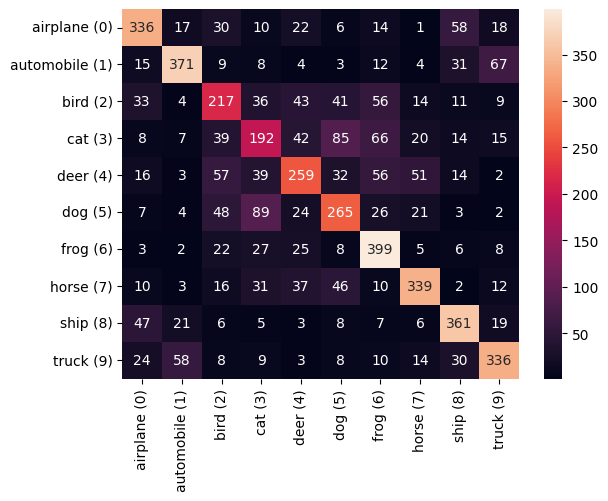

In [49]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [51]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.615


In [50]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)


                Accuracy
frog (6)        0.790099
ship (8)        0.747412
automobile (1)  0.708015
truck (9)       0.672000
horse (7)       0.669960
airplane (0)    0.656250
dog (5)         0.541922
deer (4)        0.489603
bird (2)        0.467672
cat (3)         0.393443
